In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image

from PIL import Image
from os import listdir
import csv
import random
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import random

import numpy as np
from scipy import misc
from PIL import Image
import glob
import imageio
import os

import cv2

import matplotlib.pyplot as plt

from google.colab import files

In [ ]:
from google.colab import drive #load data from your google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
class SegNet(nn.Module):
    """neural network architecture inspired by SegNet"""

    def __init__(self):
        super(SegNet, self).__init__()
        
        #Encoder
        self.conv1 = nn.Conv2d(3, 64, (3,3), padding=1)
        self.conv2 = nn.Conv2d(64, 64, (3,3), padding=1)
        self.enc1_bn = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(64, 128, (3,3), padding=1)
        self.conv4 = nn.Conv2d(128, 128, (3,3), padding=1)
        self.enc2_bn = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d((2,2),2)

        self.conv5 = nn.Conv2d(128, 256, (3,3), padding=1)
        self.conv6 = nn.Conv2d(256, 256, (3,3), padding=1)
        self.conv7 = nn.Conv2d(256, 256, (3,3), padding=1)
        self.enc3_bn = nn.BatchNorm2d(256)
        self.maxpool3 = nn.MaxPool2d((2,2),2)

        self.conv8 = nn.Conv2d(256, 512, (3,3), padding=1)
        self.conv9 = nn.Conv2d(512, 512, (3,3), padding=1)
        self.conv10 = nn.Conv2d(512, 512, (3,3), padding=1)
        self.enc4_bn = nn.BatchNorm2d(512)
        self.maxpool4 = nn.MaxPool2d((2,2),2)

        self.conv11 = nn.Conv2d(512, 512, (3,3), padding=1)
        self.conv12 = nn.Conv2d(512, 512, (3,3), padding=1)
        self.conv13 = nn.Conv2d(512, 512, (3,3), padding=1)
        self.enc5_bn = nn.BatchNorm2d(512)
        self.maxpool5 = nn.MaxPool2d((2,2),2)

        #Decoder
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.conv14 = nn.Conv2d(512,512, (3,3), padding=1)
        self.conv15 = nn.Conv2d(512,512, (3,3), padding=1)
        self.conv16 = nn.Conv2d(512,512, (3,3), padding=1)
        self.dec1_bn = nn.BatchNorm2d(512)

        self.upsample2 = nn.Upsample(scale_factor=2)
        self.conv17 = nn.Conv2d(512,512, (3,3), padding=1)
        self.conv18 = nn.Conv2d(512,512, (3,3), padding=1)
        self.conv19 = nn.Conv2d(512,256, (3,3), padding=1)
        self.dec2_bn = nn.BatchNorm2d(256)

        self.upsample3 = nn.Upsample(scale_factor=2)
        self.conv20 = nn.Conv2d(256,256, (3,3), padding=1)
        self.conv21 = nn.Conv2d(256,256, (3,3), padding=1)
        self.conv22 = nn.Conv2d(256,128, (3,3), padding=1)
        self.dec3_bn = nn.BatchNorm2d(128)

        self.upsample4 = nn.Upsample(scale_factor=2)
        self.conv23 = nn.Conv2d(128,128, (3,3), padding=1)
        self.conv24 = nn.Conv2d(128,64, (3,3), padding=1)
        self.dec4_bn = nn.BatchNorm2d(64)

        self.upsample5 = nn.Upsample(scale_factor=2)
        self.conv25 = nn.Conv2d(64,64, (3,3), padding=1)
        self.conv26 = nn.Conv2d(64,5, (3,3), padding=1)

        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x):
        #Encoder
        x = F.relu(self.enc1_bn(self.conv2(self.conv1(x))))
        #print(x.size())
        x = self.maxpool1(x)
        #print(x.size())

        x = F.relu(self.enc2_bn(self.conv4(self.conv3(x))))
        #print(x.size())
        x = self.maxpool2(x)
        #print(x.size())
        
        x = F.relu(self.enc3_bn(self.conv7(self.conv6(self.conv5(x)))))
        #print(x.size())
        x = self.maxpool3(x)
        #print(x.size())

        x = F.relu(self.enc4_bn(self.conv10(self.conv9(self.conv8(x)))))
        #print(x.size())
        x = self.maxpool4(x)
        #print(x.size())

        x = F.relu(self.enc5_bn(self.conv13(self.conv12(self.conv11(x)))))
        #print(x.size())
        x = self.maxpool5(x)
        #print(x.size())

        #print()
        #Decoder
        x = F.relu(self.dec1_bn(self.conv16(self.conv15(self.conv14(self.upsample1(x))))))
        #print(x.size())
        x = F.relu(self.dec2_bn(self.conv19(self.conv18(self.conv17(self.upsample2(x))))))
        #print(x.size())
        x = F.relu(self.dec3_bn(self.conv22(self.conv21(self.conv20(self.upsample3(x))))))
        #print(x.size())
        x = F.relu(self.dec4_bn(self.conv24(self.conv23(self.upsample4(x)))))
        #print(x.size())
        x = self.conv26(self.conv25(self.upsample4(x)))
        #print(x.size())
        
        return x

In [ ]:
def create_data(data_start, data_size, batch_size, input_path, target_path, target_dict, real_sequence, is_train):
    """create data for training/validation from img and xml to tensor"""

    transform = transforms.Compose([transforms.Resize((320, 576)),
                                     transforms.ToTensor()])

    input_list = []
    target_list = []
    data = []

    weights = [0,0,0,0,0] #weights for cross entropy loss

    pixel_class = [] #single pixel class 

    inputs = os.listdir(input_path)
    inputs.sort()

    targets = os.listdir(target_path) 
    targets.sort()
    
    

    for x in range(data_start, data_size):

        if(len(real_sequence) == 0):
            break

        #print("len sequence",len(real_sequence))

        index = random.choice(real_sequence)
        real_sequence.remove(index)
        
        print(x)


        #if(len(data) == 8 and not is_train):
        #    break

        #if(len(data) == 4):
        #    break

        input = Image.open(input_path + inputs[index])
        input_list.append(transform(input))
        #input_list.append(ToTensor()(input))

        target = Image.open(target_path + targets[index])
        target_tensor = torch.round(transform(target))
        #target_tensor = torch.round(ToTensor()(target))

        if (is_train):
            target_tensor_final = torch.zeros(320,576, dtype=torch.long) #cross entropy loss allowed only torch.long
        else:
            target_tensor_final = torch.zeros(5,320,576, dtype=torch.long)

        for i in range(320):
            for j in range(576):
                pixel_class = target_dict[tuple(target_tensor[:,i,j].tolist())]
                
                #print("pixel class", pixel_class)
                #print("tensor", torch.tensor(pixel_class, dtype=torch.long))
                #print("target size", target_tensor_final.size())
                
                if (is_train):
                    weights[pixel_class] += 1
                    target_tensor_final[i,j] = torch.tensor(pixel_class, dtype=torch.long)
                else:
                    target_tensor_final[:,i,j] = torch.tensor(pixel_class, dtype=torch.long)
                    weights[pixel_class.index(1)] += 1

        target_list.append(target_tensor_final)

        if len(input_list) >= batch_size:
            data.append((torch.stack(input_list), torch.stack(target_list)))
            
            input_list = []
            target_list = []

            print('Loaded batch ', len(data), 'of ', int(len(inputs) / batch_size))
            print('Percentage Done: ',
                  100 * (len(data) / int(len(inputs) / batch_size)), '%')

    weights = torch.tensor(weights, dtype=torch.float64)
    #weights = 1/(weights/weights.min()) #press weights in [0,1], with maximum value for each class 
    return data, weights

In [ ]:
def create_single_data(img_path):
    """create single data tensor from img_path for prediction"""

    transform = transforms.Compose([transforms.Resize((320, 576)),
                                    transforms.ToTensor()])
    input = Image.open(img_path)
    img_tensor = (transform(input)).unsqueeze(0)
        
    return img_tensor

In [ ]:
def calc_accuracy(output, target):
    """calculate accuracy from tensor(b,c,x,y) for every category c"""
    accs = []
    acc_tensor = (output == target).int()
    for c in range(target.size(1)):
        correct_num = acc_tensor[:,c].sum().item() #item convert tensor in integer
        #print(correct_num)
        total_num = acc_tensor[:,c].numel()
        #print(total_num)
        accs.append(correct_num/total_num)
    return accs

In [ ]:
def calc_precision(output, target):
    """calculate precision from tensor(b,c,x,y) for every category c"""

    precs = []
    for c in range(target.size(1)):
        true_positives = ((output[:,c] - (output[:,c] != 1).int()) == target[:,c]).int().sum().item()
        #print(true_positives)
        false_positives = ((output[:,c] - (output[:,c] != 1).int()) == (target[:,c] != 1).int()).int().sum().item()
        #print(false_positives)

        if(true_positives + false_positives == 0):
            precs.append(1.0)
        else:
            precs.append(true_positives / (true_positives + false_positives))
    
    return precs

In [ ]:
def calc_recall(output, target):
    """calculate recall from tensor(b,c,x,y) for every category c"""
    
    recs = []
    for c in range(target.size(1)):
        relevants = (target[:,c] == 1).int().sum().item()
        #print(relevants)
        true_positives = ((output[:,c] - (output[:,c] != 1).int()) == target[:,c]).int().sum().item()
        #print(true_positives)
        
        if (relevants == 0):
            recs.append(1.0)
        else:
            recs.append(true_positives/relevants)
    
    return recs

In [ ]:
def convert_to_one_hot(tensor, device):
    """converts a tensor from size (b,c,x,y) to (b,c,x,y) one hot tensor for c categorys"""

    for i in range(tensor.size(0)):
        max_idx = torch.argmax(tensor[i], 0, keepdim=True)
        one_hot = torch.FloatTensor(tensor[i].shape).to(device)
        one_hot.zero_()
        tensor[i] = one_hot.scatter_(0, max_idx, 1)

In [ ]:
def validate(val_dataset, model, device, categories):
    """
    validate the model with some validationfunctions on the test/validation dataset.

    Parameters:
        val_data (torch tensor): test/validation dataset
        model (torch.nn.module): Model to be trained
        loss (torch.nn.modules.loss): loss function like CrossEntropyLoss
        device (string): cuda or cpu
        categories (list): names of categories
    """
    model.eval()

    # avoid computation of gradients and necessary storing of intermediate layer activations
    with torch.no_grad():

        accs_avg = [0,0,0,0,0]
        precs_avg = [0,0,0,0,0]
        recs_avg = [0,0,0,0,0]
        counter = 0
        

        for (inp, target) in val_dataset:
            # transfer to device
            inp = inp.to(device)
            target = target.to(device)

            # compute output
            output = model(inp)

            #print("before extra softmax")
            #print(output[:,:,100,100])

            output = model.softmax(output)
            #print("after extra softmax")
            #print(output[:,:,100,100])

            # convert from probabilities to one hot vectors
            convert_to_one_hot(output, device)

            #print("after convert to one hot")
            #print(output[:,:,100,100])

            accs = calc_accuracy(output, target)
            precs = calc_precision(output, target)
            recs = calc_recall(output, target) 

            #print("loss {:.2} IOU {:.2}".format(loss,iou))
            
            for i in range(len(categories)):
                print("category {:10} accuracy {:.2} precision {:.2} recall {:.2} ".format(categories[i], accs[i], precs[i], recs[i]))
                accs_avg[i] += accs[i]
                precs_avg[i] += precs[i] 
                recs_avg[i] += recs[i]
            
            #print("counter", counter)
            counter += 1

    for i in range(len(categories)):
        accs_avg[i] /= counter
        precs_avg[i] /= counter
        recs_avg[i] /= counter
    
        print("avg.category {:10} accuracy {:.2} precision {:.2} recall {:.2} ".format(categories[i], accs_avg[i], precs_avg[i], recs_avg[i]))

    return [accs_avg, precs_avg, recs_avg]

In [ ]:
def create_rgb_output(data, model, device, dict_reverse):
    """create rgb pictures from model output for data (rgb-image) on device
       parameter:
            data: torch.tensor (b,5,x,y)
            model: torch#######################################################################

    """
    output = model(data.to(device))
    final_output = model.softmax(output)
    convert_to_one_hot(final_output, device)

    real_output_tensor = torch.zeros(data.size(0),3,data.size(2), data.size(3), dtype=torch.float64)

    for x in range(data.size(0)):
        for i in range(data.size(2)):
            for j in range(data.size(3)):
                real_output_tensor[x][:,i,j] = torch.tensor(dict_reverse[tuple(final_output[x,:,i,j].tolist())])

    return real_output_tensor

In [ ]:
def plot_tensor(tensor):
    """plot tensor(3,x,y) as rgb-image"""

    img = plt.imshow(tensor.permute(1,2,0))
    return img


In [ ]:
input_path = '/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/No_logo/'           #file for input images
target_path = '/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/No_logo/'           #file for target images


batch_size = 1 #batchsize for validationset

#for creating rgb pixel to class category (one_hot)
dict_val = {(0.0, 0.0, 0.0): (0.0, 1.0, 0.0, 0.0, 0.0), #black
               (0.0, 0.0, 1.0): (0.0, 1.0, 0.0, 0.0, 0.0), #black (fail)
               (0.0, 1.0, 0.0): (0.0, 0.0, 1.0, 0.0, 0.0), #green
               (0.0, 1.0, 1.0): (1.0, 0.0, 0.0, 0.0, 0.0), #white (fail)
               (1.0, 0.0, 0.0): (0.0, 0.0, 0.0, 1.0, 0.0), #red
               (1.0, 0.0, 1.0): (1.0, 0.0, 0.0, 0.0, 0.0), #white (fail)
               (1.0, 1.0, 0.0): (0.0, 0.0, 0.0, 0.0, 1.0), #yellow
               (1.0, 1.0, 1.0): (1.0, 0.0, 0.0, 0.0, 0.0)} #white

#for making model output to real output
dict_reverse = {(0.0, 1.0, 0.0, 0.0, 0.0) : (0.0, 0.0, 0.0), #black
                (0.0, 0.0, 1.0, 0.0, 0.0) : (0.0, 1.0, 0.0), #green
                (0.0, 0.0, 0.0, 1.0, 0.0) : (1.0, 0.0, 0.0), #red
                (0.0, 0.0, 0.0, 0.0, 1.0) : (1.0, 1.0, 0.0), #yellow
                (1.0, 0.0, 0.0, 0.0, 0.0) : (1.0, 1.0, 1.0)} #white

categories = ["white", "black", "green", "red", "yellow"]

In [ ]:
# set a boolean flag that indicates whether a cuda capable GPU is available
# we will need this for transferring our tensors to the device and
# for persistent memory in the data loader
is_gpu = torch.cuda.is_available()
print("GPU is available:", is_gpu)
print("If you are receiving False, try setting your runtime to GPU")

# set the device to cuda if a GPU is available
device = torch.device("cuda" if is_gpu else "cpu")

#create model
model = SegNet().to(device)

#load weights
model.load_state_dict(torch.load("/content/drive/My Drive/Autonomous Trains/Validation/Model_weights_final.pt"))
# todo: enter weigths path
print(model)

GPU is available: True
If you are receiving False, try setting your runtime to GPU
SegNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
# this cell calculates the performance on a single image.
output_path = "/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/Results/059.jpg"
target_path = "/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/Schubser Frames ground truths new/Image-0059_gt.jpg"

target = create_single_data(target_path)
#target = convert_to_one_hot(target.to(device), device)

output = create_single_data(output_path)

#output = convert_to_one_hot(output.to(device), device)
rec = calc_recall(output, target)
prec = calc_precision(output, target)
acc = calc_accuracy(output, target)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)

Accuracy: [0.82939453125, 0.8309136284722223, 0.8123318142361111]
Precision: [0.9637640804961397, 0.9589088462916743, 0.9629806667484868]
Recall: [0.8788440120261528, 0.8800196168936072, 0.8623172897277349]


In [ ]:
def get_red_pixels_from_targets(targets):
    """take a target image or NN-output and count the amount of red classifications

    targets is of shape (batch_size, num_classes, height, width)
    returns a list containing the number of red pixels in each image"""

    red_pixels = []

    for target in range(targets.size(0)):
        reds = 0
        for row in range(targets.size(2)):
            for column in range(targets.size(3)):
                if targets[target, 3, row, column] == 1:
                    reds += 1
        red_pixels.append(reds)
    
    return red_pixels

def get_yellow_pixels_from_targets(targets):
    """take a target image or NN-output and count the amount of yellow classifications pixels

    targets is of shape (batch_size, num_classes, height, width)
    returns a list containing the number of yellow pixels in each image"""

    yellow_pixels = []

    for target in range(targets.size(0)):
        yellows = 0
        for row in range(targets.size(2)):
            for column in range(targets.size(3)):
                if targets[target, 4, row, column] == 1:
                    yellows += 1
        yellow_pixels.append(yellows)
    
    return yellow_pixels

In [ ]:
# This cell was executed both with generated validation data and real validation data. Change paths and filenames accordingly.
input_path = "/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/Input/"
target_path = "/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/Schubser Frames ground truths new/"
real_sequence = list(range(len(os.listdir(input_path))))

start = 0
end = 1
while end < 11:
    val_dataset, _ = create_data(start, end, 1, input_path, target_path, dict_val, real_sequence, False) #validation tensor, first parameter is the number of images you want
    #torch.save(val_dataset, "/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/Val_Tensor_" + str(start) + ".pt")

        #val_dataset = torch.load("/content/drive/My Drive/Autonomous Trains/Validation/Val_Tensor.pt")


    results = validate(val_dataset, model, device, ["white", "black", "green", "red", "yellow"])

    with open('/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/validation_real_final.csv', 'a', newline='') as csvfile:
        mywriter = csv.writer(csvfile, delimiter=',',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
        mywriter.writerow(results)

    red_pixels_output = []
    red_pixels_target = []
    yellow_pixels_output = []
    yellow_pixels_target = []



    
    for (inp, target) in val_dataset:
        # transfer to device
        inp = inp.to(device)
        target = target.to(device)
        # compute output
        output = model(inp)

        #print("before extra softmax")
        #print(output[:,:,100,100])

        output = model.softmax(output)
        #print("after extra softmax")
        #print(output[:,:,100,100])

        # convert from probabilities to one hot vectors
        convert_to_one_hot(output, device)

        rgb_out = create_rgb_output(inp, model, device, dict_reverse)

        out = rgb_out[0]
        #fig = plt.figure()
        save_image(out, target_path + str(start) + ".jpg")

        red_pixels_target = red_pixels_target + get_red_pixels_from_targets(target)
        red_pixels_output = red_pixels_output + get_red_pixels_from_targets(output)
        yellow_pixels_target = yellow_pixels_target + get_yellow_pixels_from_targets(target)
        yellow_pixels_output = yellow_pixels_output + get_yellow_pixels_from_targets(output)
    
    # save values in csv-file
    with open('/content/drive/My Drive/Autonomous Trains/Validation/Test_Val/pixel_counts_real_all.csv', 'a', newline='') as csvfile:
        mywriter = csv.writer(csvfile, delimiter=',',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for i in range(len(red_pixels_output)):
            mywriter.writerow([red_pixels_output[i], red_pixels_target[i], yellow_pixels_output[i], yellow_pixels_target[i]])
    start = end
    end += 1
    


0
Loaded batch  1 of  11
Percentage Done:  9.090909090909092 %
category white      accuracy 0.88 precision 0.97 recall 0.91 
category black      accuracy 1.0 precision 0.86 recall 0.63 
category green      accuracy 0.93 precision 0.042 recall 0.038 
category red        accuracy 0.96 precision 0.0 recall 0.0 
category yellow     accuracy 0.97 precision 0.12 recall 0.81 
avg.category white      accuracy 0.88 precision 0.97 recall 0.91 
avg.category black      accuracy 1.0 precision 0.86 recall 0.63 
avg.category green      accuracy 0.93 precision 0.042 recall 0.038 
avg.category red        accuracy 0.96 precision 0.0 recall 0.0 
avg.category yellow     accuracy 0.97 precision 0.12 recall 0.81 
1
Loaded batch  1 of  11
Percentage Done:  9.090909090909092 %
category white      accuracy 0.9 precision 0.98 recall 0.91 
category black      accuracy 0.99 precision 0.74 recall 0.48 
category green      accuracy 0.97 precision 0.12 recall 0.06 
category red        accuracy 0.96 precision 0.0 rec

In [ ]:
def get_image_output(input_path, model, device,  output_path):
    """For a single image specified by input_path, save the NN-output at output_path.
    Was mainly used for visualization."""
    image = create_single_data(input_path)
    
    output = model(image.to(device))
    #output = model.softmax(output)
        #print("after extra softmax")
        #print(output[:,:,100,100])

        # convert from probabilities to one hot vectors
    #convert_to_one_hot(output, device)

    rgb_out = create_rgb_output(image, model, device, dict_reverse)
    save_image(rgb_out, output_path)

In [ ]:
input_path = "/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/All_Inputs/image-0059.jpg"
output_path = "/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/Results/image-0059.jpg"
get_image_output(input_path, model, device, output_path)

In [ ]:
input_path = "/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/All_Inputs/Koeln_U-Bahnstation_Apellhofplatz_warning_line.jpg"
output_path = "/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/Results/Koeln_U-Bahnstation_Apellhofplatz_warning_line_out.jpg"
get_image_output(input_path, model, device, output_path)

In [ ]:
input_path = "/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/All_Inputs/hs_2.u-bahn-munchen-harras-warning_line.jpg"
output_path = "/content/drive/My Drive/Autonomous Trains/Validation/Real_Data/Results/hs_2.u-bahn-munchen-harras-warning_line.jpg"
get_image_output(input_path, model, device, output_path)

In [ ]:
input_path = "/content/drive/My Drive/Autonomous Trains/Validation/Test_Val/Input/Input/Station10Type0Scene0back.jpg"
output_path = "/content/drive/My Drive/Autonomous Trains/Validation/Test_Val/Predictions/Station10Type0Scene0back_out.jpg"
get_image_output(input_path, model, device, output_path)

In [ ]:
input_path = "/content/drive/My Drive/Autonomous Trains/Validation/Test_Val/Input/Input/Station50Type8Scene8front.jpg"
output_path = "/content/drive/My Drive/Autonomous Trains/Validation/Test_Val/Predictions/Station50Type8Scene8front_out.jpg"
get_image_output(input_path, model, device, output_path)


In [ ]:
input_path = "/content/drive/My Drive/Autonomous Trains/Validation/Test_Val/Input/Input/Station1Type3Scene7back.jpg"
output_path = "/content/drive/My Drive/Autonomous Trains/Validation/Test_Val/Predictions/Station1Type3Scene7back_out.jpg"
get_image_output(input_path, model, device, output_path)


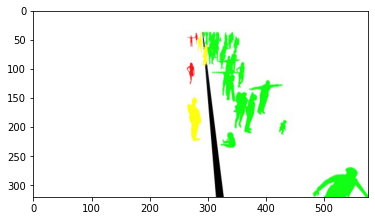

In [ ]:
#for single image
#create tensor
single_img_tensor = create_single_data('/content/drive/My Drive/Autonomous Trains/Validation/Test_Val/Target/Target/Station1Type0Scene0front.jpg')

#make prediction (to tensor size(1,5,w,h))
#output_tensor = model(single_img_tensor.to(device)) 

#make prediction (to rgb tensor size(1,3,w,h))
#output_rgb = create_rgb_output(single_img_tensor, model, device, dict_reverse)
plot_tensor(single_img_tensor[0])


In [ ]:
single_img_tensor

tensor([[[[0.7725, 0.7686, 0.7686,  ..., 0.5333, 0.6000, 0.4549],
          [0.7725, 0.7686, 0.7647,  ..., 0.5765, 0.5686, 0.5451],
          [0.7843, 0.7765, 0.7686,  ..., 0.6392, 0.6235, 0.5216],
          ...,
          [0.1843, 0.1882, 0.1843,  ..., 0.6392, 0.6431, 0.4667],
          [0.1843, 0.1843, 0.1843,  ..., 0.6078, 0.6667, 0.5922],
          [0.1882, 0.1843, 0.1843,  ..., 0.6667, 0.6431, 0.6627]],

         [[0.8667, 0.8627, 0.8627,  ..., 0.6118, 0.6824, 0.5373],
          [0.8667, 0.8627, 0.8588,  ..., 0.6549, 0.6549, 0.6275],
          [0.8784, 0.8706, 0.8627,  ..., 0.7176, 0.7020, 0.6039],
          ...,
          [0.2275, 0.2314, 0.2275,  ..., 0.7020, 0.7059, 0.5294],
          [0.2275, 0.2275, 0.2275,  ..., 0.6706, 0.7294, 0.6549],
          [0.2314, 0.2275, 0.2275,  ..., 0.7294, 0.7059, 0.7255]],

         [[0.9608, 0.9647, 0.9647,  ..., 0.7098, 0.7882, 0.6431],
          [0.9686, 0.9647, 0.9608,  ..., 0.7529, 0.7490, 0.7333],
          [0.9804, 0.9725, 0.9647,  ..., 0